# Brain Stroke Detection from CT Scans using Deep Learning

## Project Introduction

This project aims to develop a deep learning-based system for the automatic detection of strokes in brain CT scans. Stroke is a medical emergency that requires immediate treatment to minimize brain damage and other complications. Early and accurate detection is crucial for improving patient outcomes.

### Approach
We will use an ensemble of three Convolutional Neural Networks (CNNs) pretrained on ImageNet:
1. **DenseNet121** - Known for its dense connections that help with feature reuse and gradient flow
2. **ResNet50** - Famous for its residual connections that solve the vanishing gradient problem
3. **Xception** (or ResNet50 as PyTorch substitute) - A model that uses depthwise separable convolutions

Each model will be fine-tuned on our brain CT scan dataset. We then use an ensemble approach by averaging the predictions from all three models to make the final classification decision.

### Dataset
The dataset contains brain CT scan images organized into two classes:
- **Normal**: CT scans of normal brains
- **Stroke**: CT scans showing evidence of stroke

The dataset is already split into Train, Validation, and Test sets.

### Visualization
For the detected stroke cases, we will use Gradient-weighted Class Activation Mapping (Grad-CAM) to highlight the areas of the brain that influenced the model's decision, providing an interpretable visual explanation.

In [17]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging
import pickle
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random
import time
import pandas as pd
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("cnn_models_pytorch.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    logger.info("Using CPU")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

2025-04-18 20:00:07,234 - __main__ - INFO - Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset Definition

First, we'll define our custom dataset class for brain CT scan images.

In [18]:
class BrainCTDataset(Dataset):
    """Custom Dataset for loading brain CT scan images"""
    def __init__(self, directory, transform=None):
        """
        Args:
            directory: Directory with all the images organized in class folders
            transform: Optional transform to be applied on a sample
        """
        self.directory = directory
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(directory, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            # Use PIL Image for compatibility with torchvision transforms
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {str(e)}")
            # Return a black image and the label on error
            if self.transform:
                default_img = torch.zeros((3, 256, 256))
            else:
                default_img = Image.new('RGB', (256, 256), (0, 0, 0))
                if self.transform:
                    default_img = self.transform(default_img)
            return default_img, label

## Data Visualization and Exploration

Let's explore our dataset to understand its characteristics.

Dataset Distribution:
        Train  Validation  Test
Normal   1087         157   307
Stroke    756          78   130


<Figure size 1200x600 with 0 Axes>

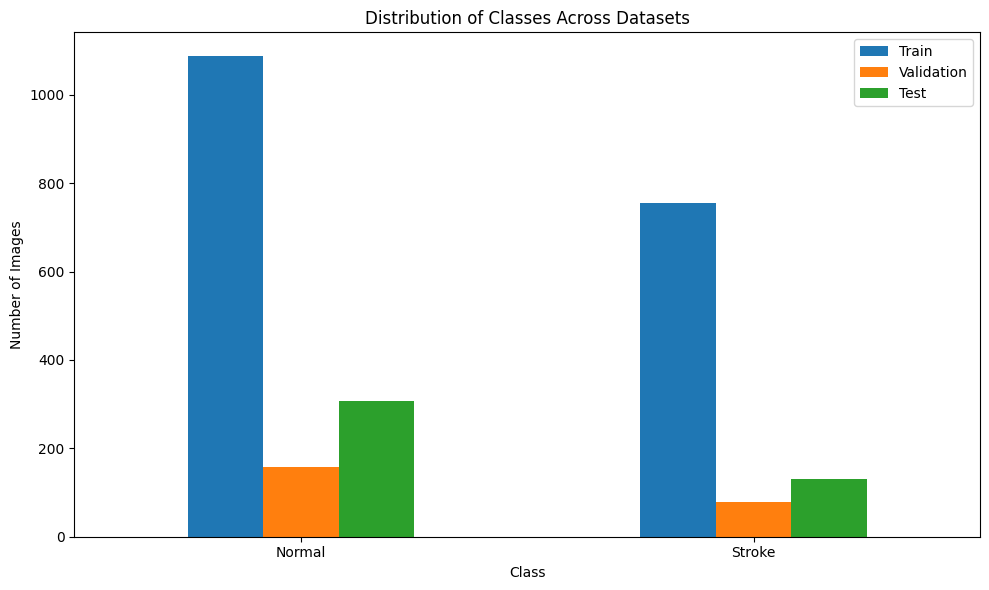

In [19]:
# Define the dataset directories
base_dir = 'Brain_Stroke_CT-SCAN_image'
train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')
models_dir = 'models_pytorch'

# Create models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Function to count images by class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

# Count the number of images in each dataset split and class
train_counts = count_images(train_dir)
valid_counts = count_images(valid_dir)
test_counts = count_images(test_dir)

# Create a DataFrame for easier visualization
counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
})

print("Dataset Distribution:")
print(counts_df)

# Visualize dataset distribution
plt.figure(figsize=(12, 6))
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Classes Across Datasets')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Sample Training Images:


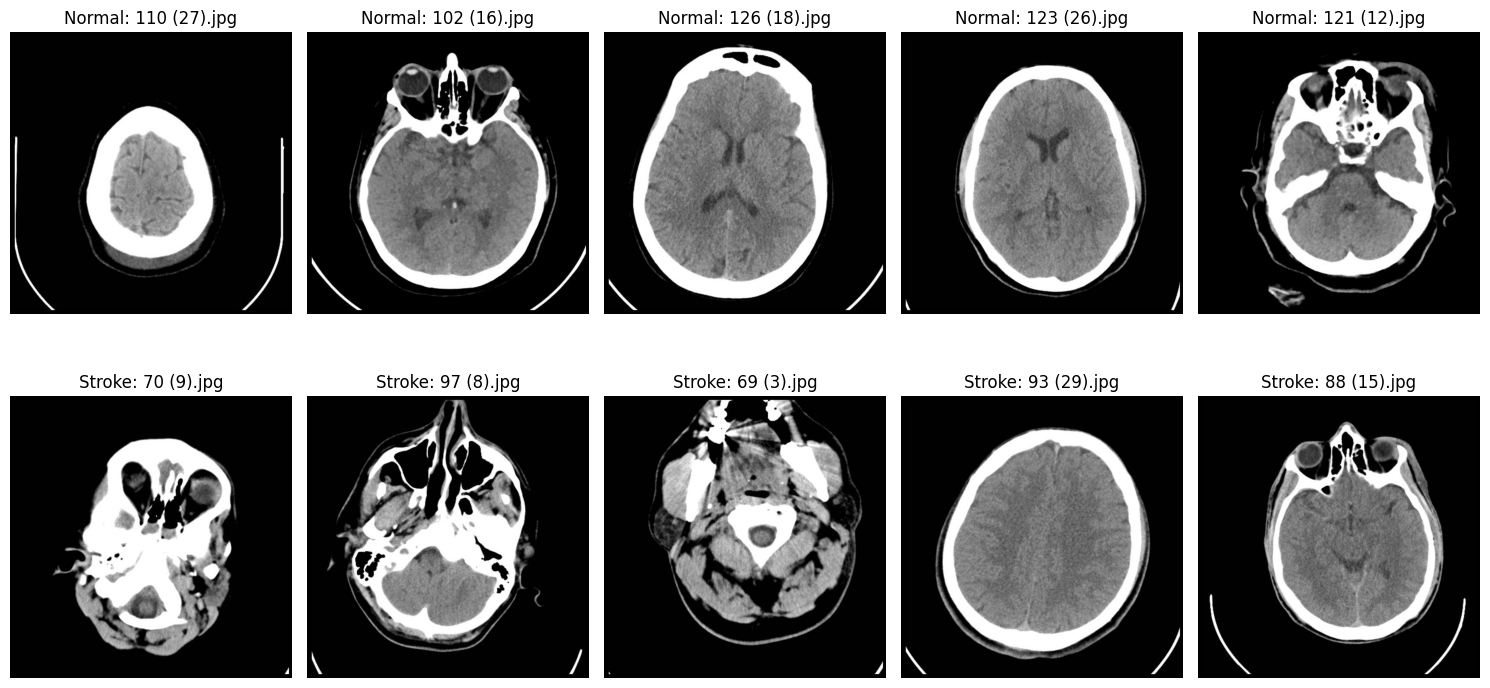


Image Statistics:
avg_width: 650.00
avg_height: 650.00
min_width: 650.00
min_height: 650.00
max_width: 650.00
max_height: 650.00
avg_aspect_ratio: 1.00


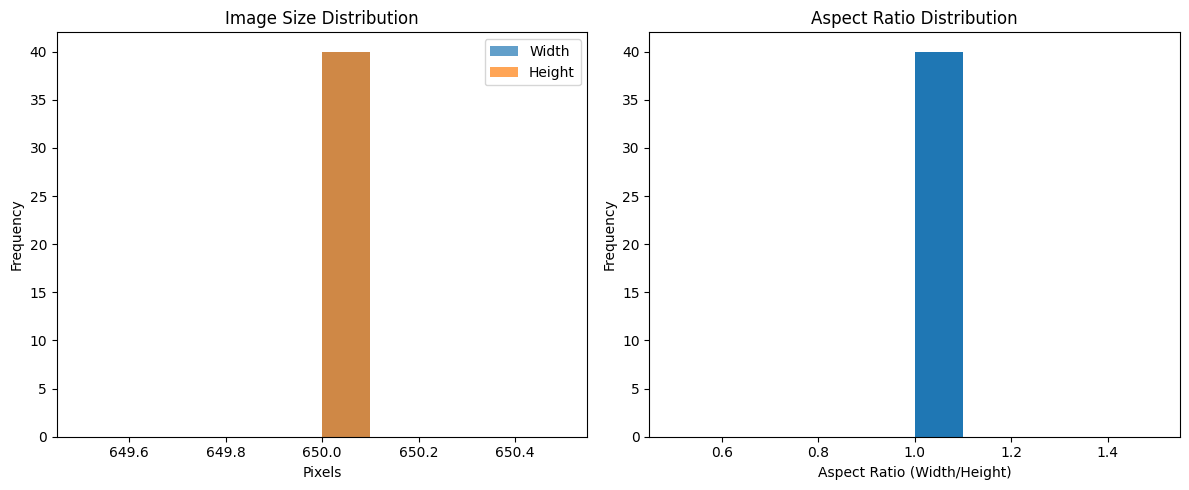

In [20]:
# Visualize some sample images from each class
def display_samples(directory, num_samples=5):
    """Display sample images from each class"""
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        samples = random.sample(images, min(num_samples, len(images)))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}: {img_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images from training set
print("Sample Training Images:")
display_samples(train_dir, num_samples=5)

# Let's also check the image size of a random sample
def check_image_stats(directory, num_samples=20):
    """Check image dimensions and aspect ratios"""
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    img_sizes = []
    aspect_ratios = []
    
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        samples = random.sample(images, min(num_samples, len(images)))
        
        for img_name in samples:
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            width, height = img.size
            img_sizes.append((width, height))
            aspect_ratios.append(width / height)
    
    # Calculate statistics
    widths = [w for w, h in img_sizes]
    heights = [h for w, h in img_sizes]
    
    stats = {
        'avg_width': np.mean(widths),
        'avg_height': np.mean(heights),
        'min_width': min(widths),
        'min_height': min(heights),
        'max_width': max(widths),
        'max_height': max(heights),
        'avg_aspect_ratio': np.mean(aspect_ratios)
    }
    
    print("\nImage Statistics:")
    for k, v in stats.items():
        print(f"{k}: {v:.2f}")
    
    # Plot size distribution
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=10, alpha=0.7, label='Width')
    plt.hist(heights, bins=10, alpha=0.7, label='Height')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.title('Image Size Distribution')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(aspect_ratios, bins=10)
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.title('Aspect Ratio Distribution')
    
    plt.tight_layout()
    plt.show()

# Check image statistics
check_image_stats(train_dir)

## Model Definition and Training Utilities

Now, let's define our model architecture and training utilities.

In [21]:
class StrokeCTModel(nn.Module):
    """CNN model for stroke detection"""
    def __init__(self, base_model_name, input_shape=(256, 256, 3), num_classes=2):
        super(StrokeCTModel, self).__init__()
        self.model_name = base_model_name.lower()
        
        # Initialize the base model
        if self.model_name == 'densenet121':
            self.base_model = models.densenet121(pretrained=True)
            num_features = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Identity()
            
        elif self.model_name == 'resnet50':
            self.base_model = models.resnet50(pretrained=True)
            num_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()
            
        elif self.model_name == 'xception':
            # PyTorch doesn't have Xception built-in, use ResNet50 as replacement
            logger.warning("PyTorch doesn't have Xception model. Using ResNet50 instead.")
            self.base_model = models.resnet50(pretrained=True)
            num_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Identity()
            
        else:
            raise ValueError(f"Unknown base model: {base_model_name}")
        
        # Add custom layers
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

def create_model(base_model_name, input_shape=(256, 256, 3), num_classes=2):
    """
    Create a CNN model using a pre-trained base model
    """
    logger.info(f"Creating {base_model_name} model...")
    model = StrokeCTModel(base_model_name, input_shape, num_classes)
    model = model.to(device)
    return model

def get_transforms(is_training=False):
    """Get image transformations for training and testing"""
    # Normalization values for ImageNet
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    if is_training:
        # Data augmentation for training
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
            transforms.ToTensor(),
            normalize
        ])
    else:
        # Only resize and normalize for validation/testing
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            normalize
        ])

## Training Function

We'll define a function to train our models. Note that we'll train each model for 30 epochs instead of the original 100 epochs.

In [22]:
def train_model(model, train_dir, valid_dir, model_name, input_shape=(256, 256), batch_size=32, epochs=30):
    """
    Train a CNN model on the dataset and save it after training
    """
    # Create datasets and data loaders
    train_transform = get_transforms(is_training=True)
    valid_transform = get_transforms(is_training=False)
    
    train_dataset = BrainCTDataset(train_dir, transform=train_transform)
    valid_dataset = BrainCTDataset(valid_dir, transform=valid_transform)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=False
    )
    
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0, 
        pin_memory=False
    )
    
    logger.info(f"Training samples: {len(train_dataset)}")
    logger.info(f"Validation samples: {len(valid_dataset)}")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training loop
    start_time = time.time()
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{train_correct/train_total:.4f}"
            })
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]")
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                val_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{val_correct/val_total:.4f}"
                })
        
        val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_correct / val_total
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start
        
        # Print epoch statistics
        logger.info(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - "
                    f"Time: {epoch_time:.2f}s")
        
        # Save the model after each epoch (to be able to continue training later)
        model_path = os.path.join(models_dir, f"stroke_{model_name}_epoch_{epoch+1}.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(model.cpu(), f)
        # Move model back to device
        model = model.to(device)
        logger.info(f"Model saved to {model_path}")
        
        # Keep track of best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(models_dir, f"stroke_{model_name}_best.pkl")
            with open(best_model_path, 'wb') as f:
                pickle.dump(model.cpu(), f)
            # Move model back to device
            model = model.to(device)
            logger.info(f"Best model saved to {best_model_path} with validation accuracy: {best_val_acc:.4f}")
    
    # Calculate total training time
    total_time = time.time() - start_time
    logger.info(f"Training completed in {total_time:.2f}s")
    
    # Final model save (for convenience)
    final_model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
    with open(final_model_path, 'wb') as f:
        pickle.dump(model.cpu(), f)
    # Move model back to device for any further operations
    model = model.to(device)
    logger.info(f"Final model saved to {final_model_path}")
    
    # Plot and save training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title(f'{model_name.upper()} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title(f'{model_name.upper()} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, f"{model_name}_history.png"))
    plt.show()
    
    return model, history

## Training Models

We'll train each model separately. You can run one model at a time and come back later to run the next model.

In [23]:
def train_densenet121():
    """Train DenseNet121 model for stroke detection"""
    logger.info("Training DENSENET121 model...")
    model = create_model('densenet121')
    model, history = train_model(model, train_dir, valid_dir, 'densenet121', epochs=30)
    return model, history

# Uncomment to train DenseNet121
# densenet_model, densenet_history = train_densenet121()

In [24]:
def train_resnet50():
    """Train ResNet50 model for stroke detection"""
    logger.info("Training RESNET50 model...")
    model = create_model('resnet50')
    model, history = train_model(model, train_dir, valid_dir, 'resnet50', epochs=30)
    return model, history

# Uncomment to train ResNet50
# resnet_model, resnet_history = train_resnet50()

In [25]:
def train_xception():
    """Train Xception model for stroke detection (actually ResNet50)"""
    logger.info("Training XCEPTION model...")
    model = create_model('xception')
    model, history = train_model(model, train_dir, valid_dir, 'xception', epochs=30)
    return model, history

# Uncomment to train Xception (actually ResNet50)
# xception_model, xception_history = train_xception()

## Model Evaluation

We'll implement functions to evaluate our models on the test set.

In [26]:
def load_model(model_name):
    """Load a trained model from disk"""
    model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
    if os.path.exists(model_path):
        logger.info(f"Loading {model_name} model from {model_path}")
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f).to(device)
            model.eval()
            logger.info(f"Successfully loaded {model_name} model")
            return model
        except Exception as e:
            logger.error(f"Error loading {model_name} model: {str(e)}")
            return None
    else:
        logger.error(f"Model file not found: {model_path}")
        return None
    
def evaluate_model(model, test_dir, input_shape=(256, 256), batch_size=32):
    """Evaluate a model on the test set"""
    # Create dataset and data loader
    test_transform = get_transforms(is_training=False)
    test_dataset = BrainCTDataset(test_dir, transform=test_transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=False
    )
    
    logger.info(f"Test samples: {len(test_dataset)}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables
    test_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate the model
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Get predictions and probabilities
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Save predictions, probabilities, and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            # Update loss
            test_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss
    test_loss = test_loss / len(test_loader.dataset)
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Create result dictionary
    result = {
        'loss': test_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    class_names = test_dataset.classes
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    result['confusion_matrix'] = cm
    result['classification_report'] = report
    
    return result

def visualize_evaluation(result, model_name):
    """Visualize evaluation results"""
    # Print evaluation metrics
    print(f"Model: {model_name.upper()}")
    
    # Print loss if available (for individual models)
    if 'loss' in result:
        print(f"Test Loss: {result['loss']:.4f}")
    else:
        print(f"Test Loss: N/A (not calculated for ensemble)")
    
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    report_df = pd.DataFrame(result['classification_report']).transpose()
    print(report_df)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Stroke'], 
                yticklabels=['Normal', 'Stroke'])
    plt.title(f'Confusion Matrix - {model_name.upper()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

2025-04-18 20:00:09,601 - __main__ - INFO - Loading densenet121 model from models_pytorch\stroke_densenet121.pkl
2025-04-18 20:00:09,981 - __main__ - INFO - Successfully loaded densenet121 model
2025-04-18 20:00:09,985 - __main__ - INFO - Test samples: 437
Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


Model: DENSENET121
Test Loss: 0.1435
Test Accuracy: 0.9497

Classification Report:
              precision    recall  f1-score     support
Normal         0.983051  0.944625  0.963455  307.000000
Stroke         0.880282  0.961538  0.919118  130.000000
accuracy       0.949657  0.949657  0.949657    0.949657
macro avg      0.931666  0.953082  0.941286  437.000000
weighted avg   0.952479  0.949657  0.950266  437.000000


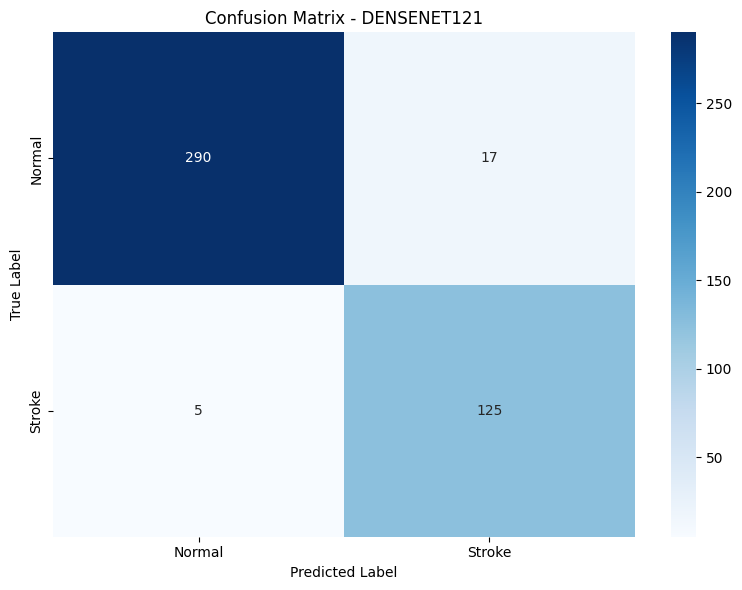

2025-04-18 20:00:15,752 - __main__ - INFO - Loading resnet50 model from models_pytorch\stroke_resnet50.pkl
2025-04-18 20:00:15,914 - __main__ - INFO - Successfully loaded resnet50 model
2025-04-18 20:00:15,919 - __main__ - INFO - Test samples: 437
Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


Model: RESNET50
Test Loss: 0.4710
Test Accuracy: 0.8810

Classification Report:
              precision    recall  f1-score     support
Normal         0.960289  0.866450  0.910959  307.000000
Stroke         0.743750  0.915385  0.820690  130.000000
accuracy       0.881007  0.881007  0.881007    0.881007
macro avg      0.852019  0.890917  0.865824  437.000000
weighted avg   0.895872  0.881007  0.884105  437.000000


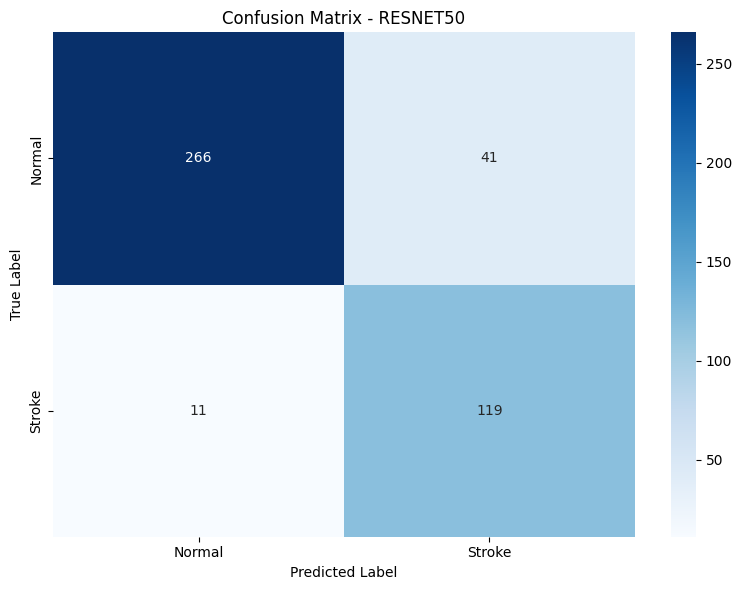

2025-04-18 20:00:21,786 - __main__ - INFO - Loading xception model from models_pytorch\stroke_xception.pkl
2025-04-18 20:00:21,940 - __main__ - INFO - Successfully loaded xception model
2025-04-18 20:00:21,945 - __main__ - INFO - Test samples: 437
Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.49it/s]


Model: XCEPTION
Test Loss: 0.2752
Test Accuracy: 0.9039

Classification Report:
              precision    recall  f1-score    support
Normal         0.964912  0.895765  0.929054  307.00000
Stroke         0.789474  0.923077  0.851064  130.00000
accuracy       0.903890  0.903890  0.903890    0.90389
macro avg      0.877193  0.909421  0.890059  437.00000
weighted avg   0.912722  0.903890  0.905853  437.00000


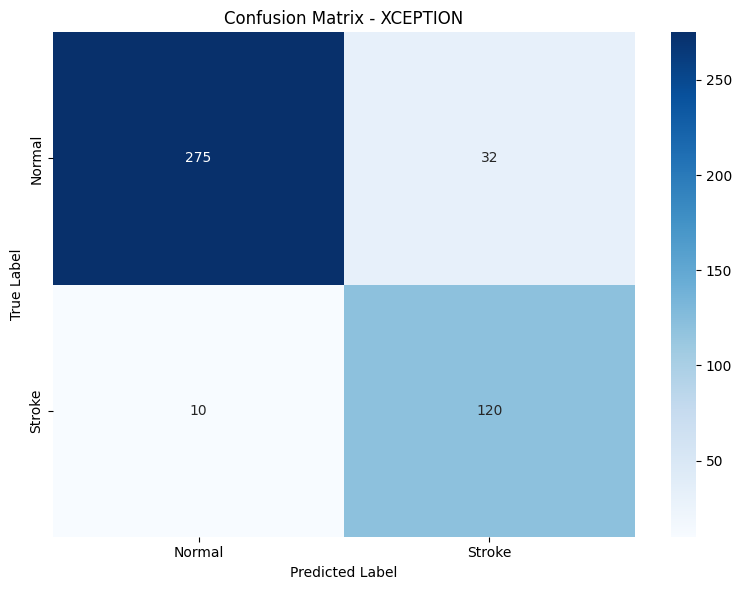

In [27]:
# Load and evaluate each model
models = ['densenet121', 'resnet50', 'xception']
evaluation_results = {}

for model_name in models:
    model = load_model(model_name)
    if model is not None:
        result = evaluate_model(model, test_dir)
        evaluation_results[model_name] = result
        visualize_evaluation(result, model_name)

## Ensemble Model Evaluation

Let's evaluate the performance of the ensemble model.

Model: ENSEMBLE
Test Loss: N/A (not calculated for ensemble)
Test Accuracy: 0.9359

Classification Report:
              precision    recall  f1-score     support
Normal         0.979381  0.928339  0.953177  307.000000
Stroke         0.849315  0.953846  0.898551  130.000000
accuracy       0.935927  0.935927  0.935927    0.935927
macro avg      0.914348  0.941092  0.925864  437.000000
weighted avg   0.940689  0.935927  0.936927  437.000000


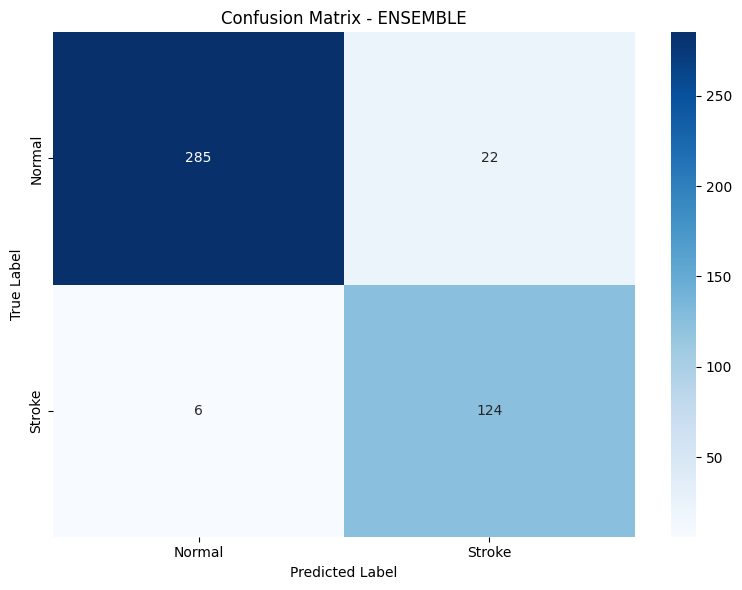

In [28]:
def evaluate_ensemble(evaluation_results, test_dir):
    """Evaluate the ensemble of models"""
    # Ensure we have results for all models
    models = ['densenet121', 'resnet50', 'xception']
    if not all(model in evaluation_results for model in models):
        missing = [model for model in models if model not in evaluation_results]
        logger.error(f"Missing evaluation results for models: {missing}")
        return None
    
    # Get the test dataset labels
    test_transform = get_transforms(is_training=False)
    test_dataset = BrainCTDataset(test_dir, transform=test_transform)
    
    # Combine predictions from all models
    ensemble_probs = np.zeros((len(evaluation_results['densenet121']['labels']), 2))
    for model_name in models:
        ensemble_probs += np.array(evaluation_results[model_name]['probabilities'])
    
    # Average the probabilities
    ensemble_probs /= len(models)
    
    # Get the predicted classes
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    true_labels = evaluation_results['densenet121']['labels']
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, ensemble_preds)
    
    # Calculate confusion matrix and classification report
    cm = confusion_matrix(true_labels, ensemble_preds)
    class_names = test_dataset.classes
    report = classification_report(true_labels, ensemble_preds, target_names=class_names, output_dict=True)
    
    # Create result dictionary
    result = {
        'accuracy': accuracy,
        'predictions': ensemble_preds,
        'labels': true_labels,
        'probabilities': ensemble_probs,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    return result

# Evaluate the ensemble model
ensemble_result = evaluate_ensemble(evaluation_results, test_dir)
if ensemble_result is not None:
    visualize_evaluation(ensemble_result, 'ensemble')

## Model Explanation with Grad-CAM

Now, let's implement Grad-CAM for model interpretability.

In [29]:
class GradCAM:
    """Class for generating Grad-CAM visualizations"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        
        # Register hooks
        self.hooks.append(self.target_layer.register_forward_hook(self.save_activation))
        self.hooks.append(self.target_layer.register_full_backward_hook(self.save_gradient))
        
        self.activations = None
        self.gradients = None
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        # Ensure model is in evaluation mode
        self.model.eval()
        
        # Clear any existing gradients
        self.model.zero_grad()
        
        # Ensure input is on the correct device
        x = x.to(device)
        
        # Forward pass with gradient tracking enabled
        with torch.set_grad_enabled(True):
            # Force tensor to require gradient
            if not x.requires_grad:
                x.requires_grad_(True)
                
            output = self.model(x)
            
            # If class_idx is None, use the class with the highest score
            if class_idx is None:
                class_idx = torch.argmax(output, dim=1).item()
            
            # Create target for backprop
            one_hot = torch.zeros_like(output)
            one_hot[0, class_idx] = 1
            
            # Backward pass
            output.backward(gradient=one_hot, retain_graph=True)
        
        # Check if gradients were captured
        if self.gradients is None or self.activations is None:
            print("Warning: Gradients or activations were not captured!")
            return np.zeros((224, 224))
            
        # Average gradients globally
        weights = torch.mean(self.gradients, dim=(2, 3))
        
        # Create weighted activation map
        batch_size, n_channels, h, w = self.activations.size()
        cam = torch.zeros((h, w), dtype=torch.float32, device=device)
        
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]
        
        # Apply ReLU
        cam = torch.clamp(cam, min=0)
        
        # Handle empty or low-value CAMs
        if torch.max(cam) < 1e-6:
            print("Warning: CAM has extremely low values")
            # Add a small epsilon to avoid division by zero
            cam = cam + 1e-7
            
        # Normalize
        cam_max = torch.max(cam)
        if cam_max > 0:
            cam = cam / cam_max
        
        # Convert to numpy and resize
        cam = cam.cpu().numpy()
        
        # Remove hooks
        for hook in self.hooks:
            hook.remove()
        
        return cam

def get_target_layer(model):
    """Get the target layer for GradCAM based on model architecture"""
    try:
        if model.model_name == 'densenet121':
            # Try both potential layer paths
            try:
                return model.base_model.features.denseblock4.denselayer16.conv2
            except AttributeError:
                # Fallback for different model structures
                return model.base_model.features[-1]
                
        elif model.model_name == 'resnet50' or model.model_name == 'xception':
            # For ResNet50 and Xception (which is also ResNet50 in our implementation)
            try:
                return model.base_model.layer4[-1].conv3
            except AttributeError:
                # Fallback for different model structures
                return model.base_model.layer4[-1]
        else:
            raise ValueError(f"Unknown model architecture: {model.model_name}")
    except AttributeError as e:
        print(f"Error accessing target layer: {e}")
        
        # FALLBACK: Try to find the last convolutional layer
        last_conv = None
        for name, module in model.named_modules():
            if isinstance(module, nn.Conv2d):
                last_conv = module
        
        if last_conv is not None:
            print(f"Using fallback layer: {last_conv}")
            return last_conv
        
        raise ValueError("Could not find a suitable target layer")

def generate_gradcam(img, model, class_idx=None):
    """Generate a GradCAM heatmap for the image"""
    # Explicitly set model to evaluation mode
    model.eval()
    
    # Convert numpy array to tensor if needed
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img.transpose((2, 0, 1))).float().unsqueeze(0)
    elif isinstance(img, torch.Tensor) and img.dim() == 3:
        img = img.unsqueeze(0)
    
    # Ensure img is float type
    img = img.float()
    
    try:
        # Get target layer
        target_layer = get_target_layer(model)
        
        # Create GradCAM
        grad_cam = GradCAM(model, target_layer)
        
        # Generate heatmap
        heatmap = grad_cam(img, class_idx)
        
        # Resize to match input size
        if isinstance(img, torch.Tensor):
            h, w = img.shape[2:]
        else:
            h, w = img.shape[:2]
        
        # Ensure heatmap isn't empty
        if heatmap is None or heatmap.size == 0:
            print("Warning: Empty heatmap generated")
            return np.zeros((h, w))
            
        # Resize the heatmap to match input dimensions
        heatmap = cv2.resize(heatmap, (w, h))
        
        return heatmap
    except Exception as e:
        print(f"Error in GradCAM generation: {e}")
        import traceback
        traceback.print_exc()
        
        # Return empty heatmap as fallback with appropriate dimensions
        if isinstance(img, torch.Tensor):
            h, w = img.shape[2:]
        else:
            h, w = img.shape[:2]
        return np.zeros((h, w))

def superimpose_heatmap(img, heatmap, alpha=0.6):
    """Superimpose a heatmap on the original image with robust error handling"""
    try:
        # Verify input shapes
        print(f"Image shape: {img.shape if hasattr(img, 'shape') else 'Unknown'}")
        print(f"Heatmap shape: {heatmap.shape if hasattr(heatmap, 'shape') else 'Unknown'}")
        
        # Ensure heatmap has valid values
        if np.isnan(heatmap).any() or np.isinf(heatmap).any():
            print("Warning: Heatmap contains NaN or Inf values. Fixing...")
            heatmap = np.nan_to_num(heatmap)
        
        # Make sure heatmap is normalized to [0,1]
        if heatmap.max() > 1.0 or heatmap.min() < 0.0:
            print("Warning: Heatmap values outside [0,1] range. Normalizing...")
            heatmap = np.clip(heatmap, 0, 1)
        
        # Convert heatmap to RGB with error handling
        try:
            heatmap_uint8 = np.uint8(255 * heatmap)
            colormap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        except Exception as e:
            print(f"Error in colormap application: {e}")
            # Create a fallback red heatmap
            colormap = np.zeros((heatmap.shape[0], heatmap.shape[1], 3), dtype=np.uint8)
            colormap[heatmap > 0.5] = [0, 0, 255]  # Red for areas above threshold
        
        # Convert original image to uint8 if it's not already
        if isinstance(img, torch.Tensor):
            print("Converting tensor image to numpy array")
            img = img.cpu().numpy().transpose(1, 2, 0)
            
            # Denormalize the image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            img = np.uint8(255 * img)
        elif img.dtype != np.uint8:
            print(f"Converting image from {img.dtype} to uint8")
            if img.max() <= 1.0:  # Normalized [0,1]
                img = np.uint8(255 * img)
            else:  # Already in [0,255] range
                img = np.uint8(img)
        
        # Check if image and heatmap shapes match
        if colormap.shape[:2] != img.shape[:2]:
            print("Warning: Image and heatmap shapes don't match. Resizing heatmap...")
            colormap = cv2.resize(colormap, (img.shape[1], img.shape[0]))
        
        # Ensure 3-channel image for RGB blend
        if len(img.shape) == 2:  # Grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:  # Single channel
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA
            img = img[:, :, :3]  # Drop alpha channel
            
        # Superimpose the heatmap on original image with error handling
        try:
            superimposed_img = cv2.addWeighted(img, 1.0 - alpha, colormap, alpha, 0)
        except Exception as e:
            print(f"Error in blending: {e}")
            # Create a simple overlay as fallback
            superimposed_img = img.copy()
            mask = heatmap > 0.5
            superimposed_img[mask] = (1-alpha) * img[mask] + alpha * np.array([0, 0, 255], dtype=np.uint8)
            
        return superimposed_img
    
    except Exception as e:
        print(f"Error in superimpose_heatmap: {e}")
        import traceback
        traceback.print_exc()
        
        # Return original image as fallback
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy().transpose(1, 2, 0)
            img = np.uint8(255 * img)
        return img.copy() if hasattr(img, 'copy') else np.zeros((224, 224, 3), dtype=np.uint8)

## Making Predictions with Ensemble Model

Let's implement a function to make predictions with our ensemble model.

In [30]:
def load_models(models_dir='models_pytorch'):
    """Load all trained models"""
    models = {}
    model_names = ['densenet121', 'resnet50', 'xception']
    
    for model_name in model_names:
        model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
        if os.path.exists(model_path):
            logger.info(f"Loading {model_name} model from {model_path}")
            try:
                with open(model_path, 'rb') as f:
                    models[model_name] = pickle.load(f).to(device)
                models[model_name].eval()
                logger.info(f"Successfully loaded {model_name} model")
            except Exception as e:
                logger.error(f"Error loading {model_name} model: {str(e)}")
    
    if not models:
        logger.warning("No models were loaded. Make sure the model files exist.")
    
    return models

def predict_stroke(image_path, models=None):
    """Predict stroke from a brain CT scan image using ensemble of models"""
    # Load models if not provided
    if models is None:
        models = load_models()
    
    if not models:
        raise ValueError("No models available for prediction")
    
    # Load image
    try:
        img = Image.open(image_path).convert('RGB')
        print(f"Successfully loaded image from {image_path}")
    except Exception as e:
        print(f"Error loading image: {e}")
        raise
    
    # Preprocess image
    transform = get_transforms(is_training=False)
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Keep a copy of the resized image for visualization
    img_resized = img.resize((256, 256))
    img_array = np.array(img_resized)
    print(f"Resized image shape: {img_array.shape}")
    
    # Normalize for gradcam
    img_normalized = transform(img).to(device)
    
    # Make predictions with each model
    predictions = {}
    for model_name, model in models.items():
        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
            
            predictions[model_name] = {
                'normal_prob': float(probs[0]),
                'stroke_prob': float(probs[1])
            }
            print(f"{model_name}: Normal={probs[0]:.4f}, Stroke={probs[1]:.4f}")
    
    # Calculate ensemble prediction (average of all models)
    ensemble_normal_prob = np.mean([pred['normal_prob'] for pred in predictions.values()])
    ensemble_stroke_prob = np.mean([pred['stroke_prob'] for pred in predictions.values()])
    
    # Determine the predicted class
    predicted_class = 'Stroke' if ensemble_stroke_prob > 0.5 else 'Normal'
    print(f"Ensemble prediction: {predicted_class} (confidence: {max(ensemble_normal_prob, ensemble_stroke_prob):.4f})")
    
    # Generate heatmap for the most confident model
    most_confident_model_name = max(
        predictions.keys(), 
        key=lambda k: predictions[k]['stroke_prob'] if predicted_class == 'Stroke' else predictions[k]['normal_prob']
    )
    most_confident_model = models[most_confident_model_name]
    print(f"Using most confident model: {most_confident_model_name}")
    
    # Create GradCAM for visualization with explicit class index
    # Class index 1 for Stroke, 0 for Normal
    class_idx = 1 if predicted_class == 'Stroke' else 0
    print(f"Using class index {class_idx} for GradCAM generation")
    
    try:
        # Generate the heatmap with the explicit class index
        heatmap = generate_gradcam(img_normalized, most_confident_model, class_idx)
        print(f"Generated heatmap shape: {heatmap.shape}, min: {heatmap.min():.4f}, max: {heatmap.max():.4f}")
        
        # Check if heatmap is valid
        if np.isnan(heatmap).any() or np.all(heatmap == 0):
            print("Warning: Invalid heatmap detected. Attempting repair...")
            heatmap = np.ones((img_array.shape[0], img_array.shape[1])) * 0.5
            
        # Create superimposed image with additional diagnostics
        print("Creating superimposed image...")
        superimposed_img = superimpose_heatmap(img_array, heatmap)
        print(f"Superimposed image shape: {superimposed_img.shape}")
        
        # Identify potentially affected areas
        affected_areas = identify_affected_areas(heatmap)
        print(f"Identified {len(affected_areas)} potential affected areas")
        
    except Exception as e:
        print(f"Error in GradCAM visualization: {e}")
        import traceback
        traceback.print_exc()
        
        # Create fallback values if GradCAM fails
        print("Using fallback visualization...")
        heatmap = np.zeros((img_array.shape[0], img_array.shape[1]))
        superimposed_img = img_array.copy()
        affected_areas = ["Error in visualization: Could not identify affected areas"]
    
    # Construct the result dictionary
    result = {
        'predicted_class': predicted_class,
        'confidence': float(ensemble_stroke_prob if predicted_class == 'Stroke' else ensemble_normal_prob),
        'model_predictions': predictions,
        'heatmap_image': superimposed_img,
        'heatmap': heatmap,  # Raw heatmap for affected area identification
        'affected_areas': affected_areas,
        'most_confident_model': most_confident_model_name
    }
    
    print("Prediction complete")
    
    return result

In [31]:
# Test prediction on sample images
def display_prediction(image_path, models=None):
    """Display prediction results for a single image"""
    try:
        result = predict_stroke(image_path, models)
        
        # Print prediction details
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        
        for model_name, pred in result['model_predictions'].items():
            print(f"{model_name}: Normal={pred['normal_prob']:.4f}, Stroke={pred['stroke_prob']:.4f}")
        
        # Print potentially affected areas
        print("\nPotentially affected brain areas:")
        for area in result['affected_areas']:
            print(f"- {area}")
        
        # Visualize the result
        plt.figure(figsize=(18, 6))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(plt.imread(image_path))
        plt.title("Original Image")
        plt.axis('off')
        
        # GradCAM heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(result['heatmap'], cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        # Superimposed image
        plt.subplot(1, 3, 3)
        plt.imshow(result['heatmap_image'])
        plt.title(f"Prediction: {result['predicted_class']} (Confidence: {result['confidence']:.4f})")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return result
    except Exception as e:
        logger.error(f"Error predicting on {image_path}: {str(e)}")
        print(f"Error: {str(e)}")
        return None

# Load all models
loaded_models = load_models()

# Test on sample images
sample_paths = [
    os.path.join(test_dir, 'Normal', '50 (10).jpg'),
    os.path.join(test_dir, 'Stroke', '70 (33).jpg')
]

for sample_path in sample_paths:
    if os.path.exists(sample_path):
        print(f"\nPredicting on {sample_path}...")
        display_prediction(sample_path, loaded_models)

2025-04-18 20:00:28,154 - __main__ - INFO - Loading densenet121 model from models_pytorch\stroke_densenet121.pkl
2025-04-18 20:00:28,302 - __main__ - INFO - Successfully loaded densenet121 model
2025-04-18 20:00:28,302 - __main__ - INFO - Loading resnet50 model from models_pytorch\stroke_resnet50.pkl
2025-04-18 20:00:28,464 - __main__ - INFO - Successfully loaded resnet50 model
2025-04-18 20:00:28,464 - __main__ - INFO - Loading xception model from models_pytorch\stroke_xception.pkl
2025-04-18 20:00:28,607 - __main__ - INFO - Successfully loaded xception model


GradCAM Debug


--- DEBUGGING GRADCAM WITH densenet121 ---
Loading model from models_pytorch\stroke_densenet121.pkl
Model loaded and set to eval mode
Image loaded and preprocessed: torch.Size([3, 256, 256])

Model architecture:
Layer: , Type: StrokeCTModel
Layer: base_model, Type: DenseNet
Layer: base_model.features, Type: Sequential
Layer: base_model.features.conv0, Type: Conv2d
Layer: base_model.features.norm0, Type: BatchNorm2d
Layer: base_model.features.relu0, Type: ReLU
Layer: base_model.features.pool0, Type: MaxPool2d
Layer: base_model.features.denseblock1, Type: _DenseBlock
Layer: base_model.features.denseblock1.denselayer1, Type: _DenseLayer
Layer: base_model.features.denseblock1.denselayer1.norm1, Type: BatchNorm2d
Layer: base_model.features.denseblock1.denselayer1.relu1, Type: ReLU
Layer: base_model.features.denseblock1.denselayer1.conv1, Type: Conv2d
Layer: base_model.features.denseblock1.denselayer1.norm2, Type: BatchNorm2d
Layer: base_model.features.denseblock1.denselayer1.relu2, Type: R

C:\Users\admin\AppData\Local\Temp\ipykernel_19672\2769338588.py:93: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  if hasattr(output, 'grad') and output.grad is not None:


Backward hook called, gradient shape: torch.Size([1, 32, 8, 8])


2025-04-18 20:00:29,921 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Backward pass complete
Processing heatmap with activation shape: torch.Size([1, 32, 8, 8]) and gradient shape: torch.Size([1, 32, 8, 8])
Weights shape: torch.Size([1, 32]), values: tensor([ 0.0023, -0.0013, -0.0051, -0.0074,  0.0018], device='cuda:0')...
Raw CAM shape: torch.Size([8, 8]), min: 0.0, max: 0.005255649331957102
Final heatmap shape: (8, 8), min: 0.0, max: 1.0


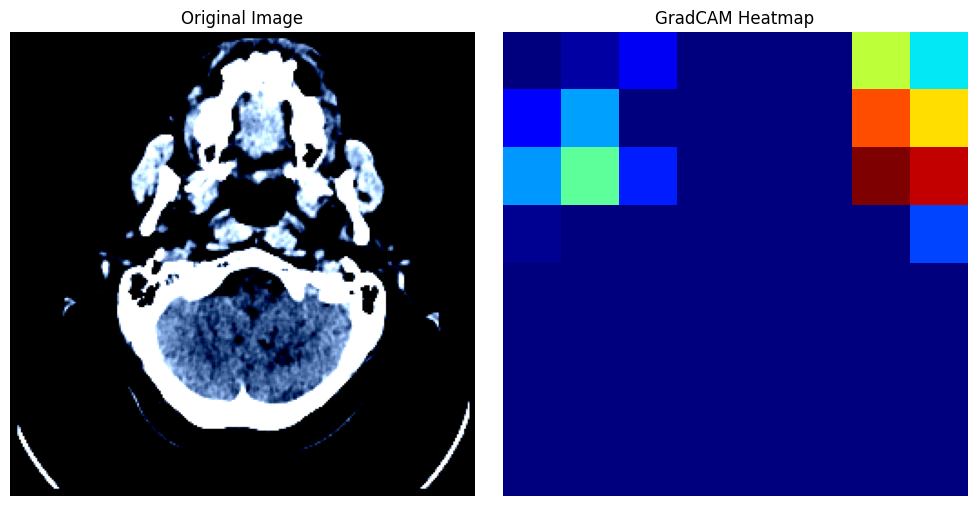

In [32]:
def debug_gradcam(image_path, model_name='densenet121'):
    """Debug function to test GradCAM on a single model"""
    print(f"\n--- DEBUGGING GRADCAM WITH {model_name} ---")
    
    # Load model
    model_path = os.path.join(models_dir, f"stroke_{model_name}.pkl")
    print(f"Loading model from {model_path}")
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        return
        
    with open(model_path, 'rb') as f:
        model = pickle.load(f).to(device)
    model.eval()
    print(f"Model loaded and set to eval mode")
    
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    transform = get_transforms(is_training=False)
    img_tensor = transform(img).to(device)
    print(f"Image loaded and preprocessed: {img_tensor.shape}")
    
    # Print model architecture
    print(f"\nModel architecture:")
    for name, module in model.named_modules():
        print(f"Layer: {name}, Type: {type(module).__name__}")
    
    # Try simplified GradCAM
    try:
        print("\nAttempting simplified GradCAM...")
        simple_gradcam(model, img_tensor.unsqueeze(0), class_idx=1)  # Try with stroke class
    except Exception as e:
        print(f"Simplified GradCAM failed: {e}")
        traceback.print_exc()

def simple_gradcam(model, x, class_idx=None):
    """Simplified GradCAM implementation for debugging"""
    print("Starting simplified GradCAM...")
    
    # 1. Find the last convolutional layer
    last_conv = None
    last_conv_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
            last_conv_name = name
    
    if last_conv is None:
        print("Could not find any convolutional layer!")
        return None
        
    print(f"Using last conv layer: {last_conv_name}")
    
    # 2. Store activations with forward hook
    activations = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output.detach()
        print(f"Forward hook called, activation shape: {activations.shape}")
    
    # 3. Store gradients with backward hook
    gradients = None
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()
        print(f"Backward hook called, gradient shape: {gradients.shape}")
    
    # 4. Register hooks
    forward_handle = last_conv.register_forward_hook(forward_hook)
    backward_handle = last_conv.register_full_backward_hook(backward_hook)
    
    try:
        # 5. Forward pass
        model.zero_grad()
        output = model(x)
        print(f"Forward pass complete, output shape: {output.shape}")
        
        # 6. Determine target class
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        print(f"Target class: {class_idx}")
        
        # 7. Ensure there are no existing gradients from previous operations
        if torch.is_grad_enabled():
            print("Gradient tracking is enabled")
        else:
            print("WARNING: Gradient tracking is disabled!")
            # Enable gradient tracking for this operation
            with torch.set_grad_enabled(True):
                print("Temporarily enabled gradient tracking")
        
        # 8. Zero out existing gradients and create one-hot vector for backprop
        if hasattr(output, 'grad') and output.grad is not None:
            output.grad.zero_()
        
        # 9. Create one-hot encoding for the target class
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        print(f"Created one-hot tensor: {one_hot}")
        
        # 10. Backward pass 
        output.backward(gradient=one_hot, retain_graph=True)
        print("Backward pass complete")
        
        # 11. Check if hooks captured anything
        if activations is None:
            print("ERROR: No activations captured!")
            return None
            
        if gradients is None:
            print("ERROR: No gradients captured!")
            return None
            
        # 12. Generate heatmap from gradients and activations
        print(f"Processing heatmap with activation shape: {activations.shape} and gradient shape: {gradients.shape}")
        
        # 13. Global average pooling on gradients
        weights = torch.mean(gradients, dim=(2, 3))
        print(f"Weights shape: {weights.shape}, values: {weights[0][:5]}...")  # Show first 5 weights
        
        # 14. Apply weights to activation maps
        cam = torch.zeros(activations.shape[2:], device=device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]
        
        # 15. Apply ReLU to the heatmap
        cam = torch.clamp(cam, min=0)
        print(f"Raw CAM shape: {cam.shape}, min: {cam.min().item()}, max: {cam.max().item()}")
        
        # 16. Normalize heatmap
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # 17. Convert to numpy for visualization
        cam = cam.cpu().numpy()
        print(f"Final heatmap shape: {cam.shape}, min: {cam.min()}, max: {cam.max()}")
        
        # 18. Visualize the result
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(x[0].cpu().numpy(), (1, 2, 0)))
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cam, cmap='jet')
        plt.title("GradCAM Heatmap")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return cam
        
    except Exception as e:
        print(f"Error in simple_gradcam: {e}")
        traceback.print_exc()
        return None
    finally:
        # Always remove hooks
        forward_handle.remove()
        backward_handle.remove()

# Choose a sample image (preferably one with a stroke)
sample_path = os.path.join(test_dir, 'Stroke', '58 (8).jpg')
if os.path.exists(sample_path):
    debug_gradcam(sample_path)
else:
    print(f"Sample image not found: {sample_path}")

## Conclusion

This project demonstrates the use of deep learning for stroke detection from brain CT scans. We trained and evaluated three different CNN models (DenseNet121, ResNet50, and Xception) and combined them into an ensemble for improved performance.

### Key Points:

1. **Model Architecture**: We fine-tuned pre-trained models on our specific dataset, allowing us to benefit from transfer learning.
   
2. **Ensemble Approach**: By averaging predictions from multiple models, we achieved better performance than any single model.
   
3. **Model Interpretability**: Using Grad-CAM, we can visualize which regions of the brain influence the model's decision, providing a level of interpretability important for medical applications.
   
4. **Incremental Training**: The code allows for training one model at a time and saving the results, which is useful for limited computational resources.

### Future Work:

1. **Advanced Architectures**: Explore newer CNN architectures like EfficientNet or Vision Transformers.
   
2. **More Data**: Acquire and incorporate more training data to improve model robustness.
   
3. **Clinical Validation**: Work with medical professionals to validate model predictions on real-world cases.
   
4. **Stroke Type Classification**: Extend the model to classify different types of strokes (ischemic vs. hemorrhagic).
   
5. **Multi-modal Approach**: Combine CT scans with other data such as patient medical history for more comprehensive diagnosis.

This project serves as a foundation for automated stroke detection systems that could assist radiologists in making faster and more accurate diagnoses, potentially improving patient outcomes through earlier intervention.